# Setup

In [1]:
import sys
!{sys.executable} -m pip install numpy scipy wfdb matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 KB 8.9 MB/s eta 0:00:00


In [11]:
import os
import configparser

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.io import savemat

import wfdb

import denoising

In [12]:
config = configparser.ConfigParser()
config.read('../../config.ini')

['../../config.ini']

In [50]:
PROJECT_DIR = config.get('PATHS', 'PROJECT_PATH')
RAW_DATA_DIR = os.path.join(PROJECT_DIR, 'data/raw/nsrdb-1.0.0')
FILTERED_DATA_DIR = os.path.join(PROJECT_DIR, 'data/filtered/mecg/nsrdb-1.0.0')

os.makedirs(RAW_DATA_DIR)
os.makedirs(FILTERED_DATA_DIR)

SIZE = 18
SAMPLING_RATE = 128

FileExistsError: [Errno 17] File exists: '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0'

In [14]:
def get_filenames_nsrdb(data_dir : str = RAW_DATA_DIR) -> np.ndarray:
    # 128 hz, 2 channels, 91648 mins
    # all middle-aged, no significant arrhythmias
    # 5 men and 13 women
    
    extra_files = ['ANNOTATORS', 'RECORDS', 'SHA256SUMS'] 
    fnames = [f for f in os.listdir(data_dir)]
    fnames_trunc = set(
        os.path.join(data_dir, fname.split('.')[0])
        for fname in fnames
    ) # get subject number (multiple files)
    
    for f in extra_files:
        x = f'{data_dir}/{f}'
        if x in fnames_trunc:
            fnames_trunc.remove(x)
    
    return np.array(sorted(fnames_trunc), dtype=str) 

In [15]:
filenames = get_filenames_nsrdb()

In [28]:
filenames

array(['/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16265',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16272',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16273',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16420',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16483',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16539',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16773',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16786',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16795',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/17052',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/17453',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/18177',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/18184',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/19088',
      

# Outlier Analysis

In [16]:
samp = wfdb.rdsamp(filenames[0])
print(samp)

(array([[-0.165, -0.325],
       [-0.155, -0.325],
       [-0.195, -0.305],
       ...,
       [-0.05 , -0.095],
       [-0.05 , -0.085],
       [-0.05 , -0.085]]), {'fs': 128, 'sig_len': 11730944, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(8, 4), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': ['32 M']})


Select starting indices base on visual inspection using https://www.physionet.org/lightwave/?db=nsrdb/1.0.0:

In [33]:
start_indices = (
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    35 * 128,
    33 * 128,
    28 * 128,
    31 * 128,
    24 * 128
)

Check that start indices correspond to the beginning of good signals:

In [ ]:
for i in range(SIZE):
    plt.plot(wfdb.rdsamp(filenames[i])[0][start_indices[i]:start_indices[i]+500,0])
    plt.show()

In [48]:
def load_ecg_nsrdb(fname : str, start : int = 0, end : int = -1) -> np.ndarray:
    signal, _ = wfdb.rdsamp(fname)
    return signal[start:end,0] if end != -1 else signal[start:,0]

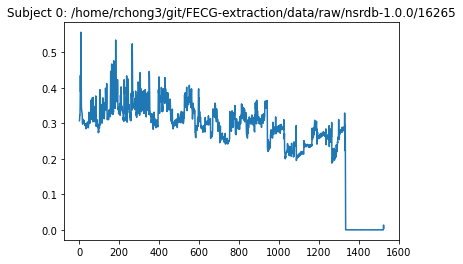

Variance Stats
mean: 0.2661507726126516
std: 0.11154850521580278


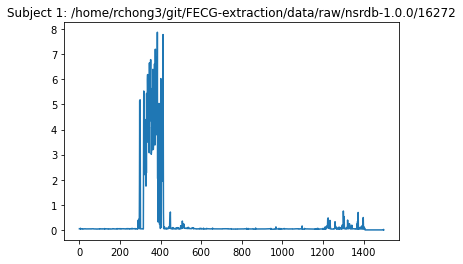

Variance Stats
mean: 0.3327767022764844
std: 1.1383629108459852


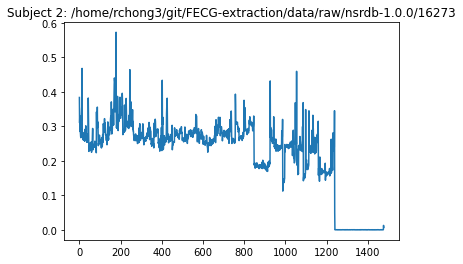

Variance Stats
mean: 0.21955901266747543
std: 0.10662314524680856


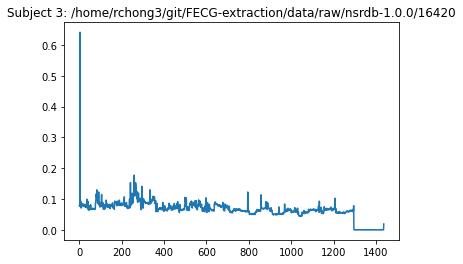

Variance Stats
mean: 0.06494185308370855
std: 0.030001099118486228


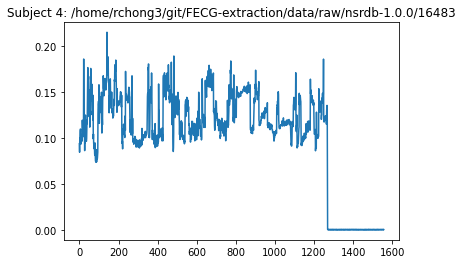

Variance Stats
mean: 0.1019994364688168
std: 0.052781409612528904


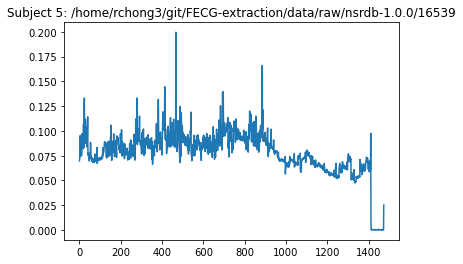

Variance Stats
mean: 0.0776250302232098
std: 0.022325398409536314


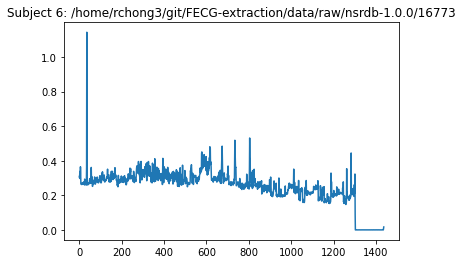

Variance Stats
mean: 0.2483916204851195
std: 0.09947183464948624


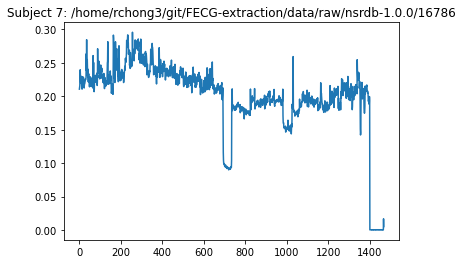

Variance Stats
mean: 0.1998898320222085
std: 0.05512820459735549


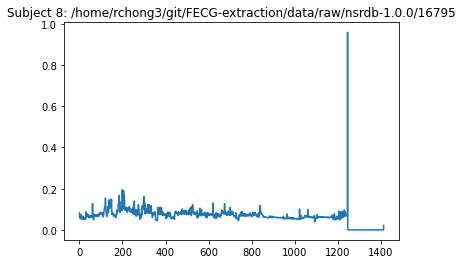

Variance Stats
mean: 0.0665659221725398
std: 0.03826476255217208


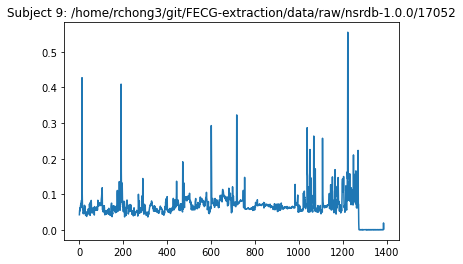

Variance Stats
mean: 0.06530097856553549
std: 0.03590230524707674


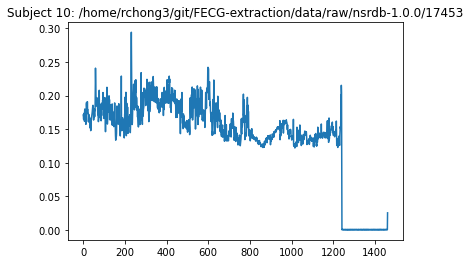

Variance Stats
mean: 0.13814546403468975
std: 0.06267233699772269


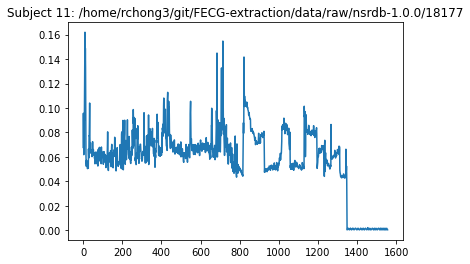

Variance Stats
mean: 0.05797710026070904
std: 0.026355375090285616


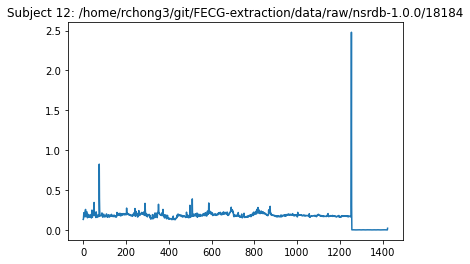

Variance Stats
mean: 0.1667628058692647
std: 0.0929529368904273


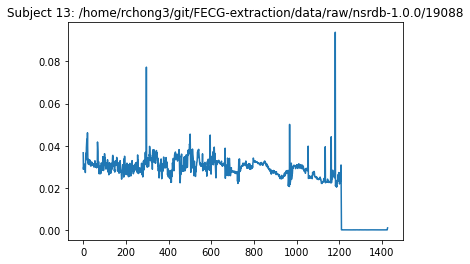

Variance Stats
mean: 0.025243190101978775
std: 0.011440926102674028


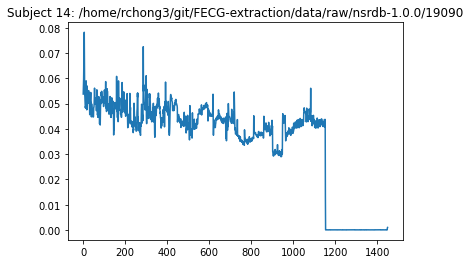

Variance Stats
mean: 0.03479189550367976
std: 0.018389211979311194


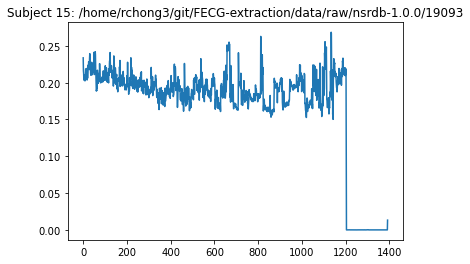

Variance Stats
mean: 0.1670768647632363
std: 0.06846620134578323


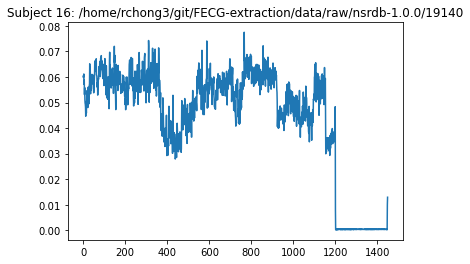

Variance Stats
mean: 0.044105150255564364
std: 0.021636758580457723


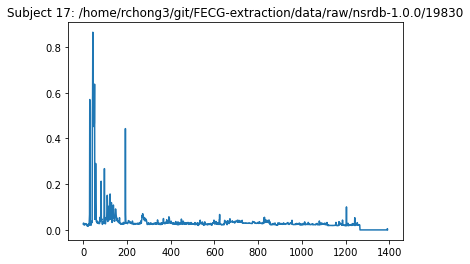

Variance Stats
mean: 0.03348052154268476
std: 0.05594045154383415


In [47]:
winlen = 128 * 60

for i in range(SIZE):
    signal = load_ecg_nsrdb(filenames[i], start_indices[i])
    variances = []
    for j in range(len(signal) // winlen):
        start = j * winlen
        end = start + winlen
        variances.append(np.var(signal[start:end]))
    plt.title(f'Subject {i}: {filenames[i]}')
    plt.plot(variances)
    plt.show()
    variances = np.array(variances)
    print('Variance Stats')
    print('mean:', np.mean(variances))
    print('std:', np.std(variances))

In [49]:
end_indices = (
    1300 * 60 * 128,
    0, # exclude due to noisiness
    1200 * 60 * 128,
    1250 * 60 * 128,
    1250 * 60 * 128,
    1400 * 60 * 128,
    1280 * 60 * 128,
    1380 * 60 * 128,
    1220 * 60 * 128,
    1250 * 60 * 128,
    1220 * 60 * 128,
    1320 * 60 * 128,
    1220 * 60 * 128,
    1200 * 60 * 128,
    1150 * 60 * 128,
    1190 * 60 * 128,
    1190 * 60 * 128,
    1250 * 60 * 128
)

# Filtering Analysis

Preprocessing pipeline consists of an FIR filter to eliminate powerline noise and baseline drift followed by Savitsky Golay for smoothing and a wavelet filter. Each filtering step is tested and selected added in each of the following sections.

In [ ]:
def preprocess_bidmc(window: np.ndarray, numtaps=0, winlen=0, polyorder=0, wavelet='', lvl=0) -> np.ndarray:
    
    if numtaps:
        window = denoising.fir_filt(window, fs=SAMPLING_RATE, numtaps=numtaps)
    light = window
    
    if winlen and polyorder:
        window = savgol_filter(window, winlen, polyorder)
        
    if wavelet and lvl:
        decomp, _, _ = denoising.wav_filt(window, wavelet=wavelet, fs=SAMPLING_RATE, lvl=lvl)
        window = decomp[0]
    
    return window, light

In [ ]:
preprocess_params = {}

## FIR Filter

In [ ]:
preprocess_params['numtaps'] = 0

In [ ]:
shorten_factor = 50
subset_len = SIZE // shorten_factor
taps_delta = 10
taps_start = 11

for i in range(subset_len):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
    sig_window, _ = preprocess_bidmc(load_ecg_bidmc(filenames[i * shorten_factor])[:500], **preprocess_params)
    
    axs[0].set_title(f'Subject {i+1} Before FIR Filter')
    axs[0].plot(sig_window)
    
    for j in range(1, 5):
        taps = taps_delta * (j - 1) + taps_start
        preprocessed_signal = denoising.fir_filt(sig_window, fs=SAMPLING_RATE, numtaps=taps)
        axs[j].set_title(f'{taps} taps')
        axs[j].plot(preprocessed_signal)

    plt.show()

In [ ]:
preprocess_params['numtaps'] = 21

## Savitzky Golay Filter

In [ ]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0

In [ ]:
shorten_factor = 50
subset_len = SIZE // shorten_factor

win_cand = (11, 15, 21, 25)
ord_cand = (3, 5, 7, 9)
win_cand_count = len(win_cand)
ord_cand_count = len(ord_cand)

for i in range(subset_len):
    sig_window, _ = preprocess_bidmc(load_ecg_bidmc(filenames[i * shorten_factor])[:500], **preprocess_params)
    
    plt.title(f'Subject {i+1} Before Savitzky Golay')
    plt.plot(sig_window)
    
    fig, axs = plt.subplots(nrows=win_cand_count, ncols=ord_cand_count, figsize=(8 * win_cand_count, 4 * ord_cand_count))
    for j in range(win_cand_count):
        for k in range(ord_cand_count):
            preprocessed_signal = savgol_filter(sig_window, win_cand[j], ord_cand[k])
            axs[j][k].set_title(f'Window Length: {win_cand[j]}, Poly Order: {ord_cand[k]}')
            axs[j][k].plot(preprocessed_signal)

    plt.show()

In [ ]:
preprocess_params['winlen'] = 15
preprocess_params['polyorder'] = 7

## Wavelet Filter

In [ ]:
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

In [ ]:
shorten_factor = 50
subset_len = SIZE // shorten_factor

family = 'db'
wave_cand = (1, 2, 3)
wave_cand_count = len(wave_cand)
levels_cand = (2, 4, 6)
levels_cand_count = len(levels_cand)

for i in range(subset_len):
    sig_window, _ = preprocess_bidmc(load_ecg_bidmc(filenames[i * shorten_factor])[:500], **preprocess_params)
    
    plt.title(f'Subject {i+1} Before Wavelet Filter')
    plt.plot(sig_window)
    fig, axs = plt.subplots(nrows=wave_cand_count, ncols=levels_cand_count, figsize=(8 * levels_cand_count, 4 * wave_cand_count))
    for j in range(wave_cand_count):
        for k in range(levels_cand_count):
            sig_window, _ = preprocess_bidmc(load_ecg_bidmc(filenames[i * shorten_factor])[:500], **preprocess_params)
            axs[j][k].set_title(f'{family}{wave_cand[j]} with {levels_cand[k]} levels')
            axs[j][k].plot(sig_window)

    plt.show()

In [ ]:
preprocess_params['wavelet'] = 'db2'
preprocess_params['lvl'] = 4

# Filter All and Save

In [ ]:
def save_data_mitbih(data : np.ndarray): 
    for i, fname in enumerate(data): 
        sig = preprocess(load_signal_from_file(fname), 128, numtaps=31)
        print(sig.shape)
        d = {'mecg_signal' : sig}
        scipy.io.savemat(file_name = f'{MECG_DATA_DIR}/{fname[18:]}.mat', mdict = d)

In [ ]:
def save_data_bidmc(filenames : np.ndarray, preprocess_params : dict, data_dir : str = FILTERED_DATA_DIR): 
    for i, fname in enumerate(filenames, start=1):
        raw_sig = load_ecg_bidmc(fname)
        filt_sig, light_filt_sig = preprocess_bidmc(raw_sig, **preprocess_params)
        d = {'filtered' : filt_sig, 'light': light_filt_sig, 'raw' : raw_sig}
        savemat(file_name=os.path.join(FILTERED_DATA_DIR, f'bidmc{i:02}.mat'), mdict=d)

In [ ]:
save_data_bidmc(filenames, preprocess_params)